In [1]:
from velocity_plot import velocity_plot as vpl
from turtle import color
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from sampling import *
import pandas as pd
from colormap import *
import random
import os

from scipy.spatial.distance import squareform
from fastcluster import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

import multiprocessing as mp



# Required:
#!pip install dtw-python
#!pip install fastcluster

In [2]:
def corr_coeff(ematrix, vmatrix, i):
    '''
    Calculate the correlation between the predict velocity (velocity_matrix[:,i])
    and the difference between a cell and every other (cell_matrix - cell_matrix[:, i])
    '''
    # ematrix = cell_matrix
    # vmatrix = velocity_matrix
    ematrix = ematrix.T
    vmatrix = vmatrix.T
    ematrix = ematrix - ematrix[i, :]
    vmatrix = vmatrix[i, :][None, :]
    ematrix_m = ematrix - ematrix.mean(1)[:, None]
    vmatrix_m = vmatrix - vmatrix.mean(1)[:, None]

    # Sum of squares across rows
    ematrix_ss = (ematrix_m**2).sum(1)
    vmatrix_ss = (vmatrix_m**2).sum(1)
    cor = np.dot(ematrix_m, vmatrix_m.T) / \
        np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))
    return cor.T


def velocity_correlation(cell_matrix, velocity_matrix):
    """Calculate the correlation between the predict velocity (velocity_matrix[:,i])
    and the difference between a cell and every other (cell_matrix - cell_matrix[:, i])

    Arguments
    ---------
    cell_matrix: np.ndarray (ngenes, ncells)
        gene expression matrix
    velocity_matrix: np.ndarray (ngenes, ncells)
    Return
    ---------
    c_matrix: np.ndarray (ncells, ncells)
    """
    c_matrix = np.zeros((cell_matrix.shape[1], velocity_matrix.shape[1]))
    for i in range(cell_matrix.shape[1]):
        c_matrix[i, :] = corr_coeff(cell_matrix, velocity_matrix, i)[0, :]
    
    
    np.fill_diagonal(c_matrix, 0)
    return c_matrix


def velocity_projection(cell_matrix, velocity_matrix, embedding, knn_embedding):
    '''
    cell_matrix: np.ndarray (ngenes, ncells)
        gene expression matrix
    velocity_matrix: np.ndarray (ngenes, ncells)
    '''
    # cell_matrix = np_s0[:,sampling_ixs]
    # velocity_matrix = np_dMatrix[:,sampling_ixs]
    
    sigma_corr = 0.05
    cell_matrix[np.isnan(cell_matrix)] = 0
    velocity_matrix[np.isnan(velocity_matrix)] = 0
    corrcoef = velocity_correlation(cell_matrix, velocity_matrix)
    probability_matrix = np.exp(corrcoef / sigma_corr)*knn_embedding.A
    probability_matrix /= probability_matrix.sum(1)[:, None]
    unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
    with np.errstate(divide='ignore', invalid='ignore'):
        unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)
        np.fill_diagonal(unitary_vectors[0, ...], 0)
        np.fill_diagonal(unitary_vectors[1, ...], 0)
    velocity_embedding = (probability_matrix * unitary_vectors).sum(2)
    velocity_embedding -= (knn_embedding.A * unitary_vectors).sum(2) / \
        knn_embedding.sum(1).A.T  # embedding_knn.A *
    velocity_embedding = velocity_embedding.T
    
    return velocity_embedding, probability_matrix


def data_reshape(load_cellDancer):
    '''
    load detail file
    return expression matrix and velocity (ngenes, ncells)
    '''
    psc = 1
    gene_names = load_cellDancer['gene_name'].drop_duplicates().to_list()
    # cell_number = load_cellDancer[load_cellDancer['gene_name']==gene_names[0]].shape[0]
    # load_cellDancer['index'] = np.tile(range(cell_number),len(gene_names))
    load_cellDancer['index'] = 0
    for g in gene_names:
        load_cellDancer.loc[load_cellDancer['gene_name'] == g, 'index'] = range(
            load_cellDancer[load_cellDancer['gene_name'] == g].shape[0])
    s0_reshape = load_cellDancer.pivot(
        index='gene_name', values='s0', columns='index')
    s1_reshape = load_cellDancer.pivot(
        index='gene_name', values='s1', columns='index')
    dMatrix = s1_reshape-s0_reshape
    np_s0_reshape = np.array(s0_reshape)
    np_dMatrix = np.array(dMatrix)
    np_dMatrix2 = np.sqrt(np.abs(np_dMatrix) + psc) * \
        np.sign(np_dMatrix)  # (2159, 18140)
    return(np_s0_reshape, np_dMatrix2)


In [3]:
raw_data_path = "/Users/pengzhizhang/Documents/test_data/denGyr_full.csv"
load_raw_data = pd.read_csv(raw_data_path, names=[
                            'gene_list', 'u0', 's0', "clusters", 'cellID', 'embedding1', 'embedding2'])

detail_result_path = '/Users/pengzhizhang/Documents/test_data'
output_path = '/Users/pengzhizhang/Documents/test_data'

In [4]:
load_cellDancer = pd.read_csv('/Users/pengzhizhang/Documents/test_data/detail_e307.csv')

In [5]:
gene_choice=list(set(load_cellDancer.gene_name))
n_neighbors=100
add_amt_gene=10
data_df = load_raw_data[['gene_list', 'u0', 's0', 'cellID',
                             'embedding1', 'embedding2']][load_raw_data.gene_list.isin(gene_choice)]

random.seed(10)
embedding_downsampling, sampling_ixs, knn_embedding = downsampling_embedding(data_df,
                                                                            para='neighbors',
                                                                            target_amount=0,
                                                                            step_i=60,
                                                                            step_j=60,
                                                                            n_neighbors=n_neighbors)

ncells = sampling_ixs.shape[0]

neighbors


In [6]:
np_s0, np_dMatrix = data_reshape(load_cellDancer)  # 2min for 200 genes
np_dMatrix_all=np_dMatrix
np_s0_all=np_s0

In [7]:
embedding_df = load_raw_data[load_raw_data.gene_list == list(
    load_raw_data.gene_list[0])[0]][['embedding1', 'embedding2']]

embedding = embedding_df.to_numpy()

velocity_embedding, probability_matrix = velocity_projection(
    np_s0_all[:, sampling_ixs], 
    np_dMatrix_all[:, sampling_ixs], 
    embedding[sampling_ixs, :], 
    knn_embedding)

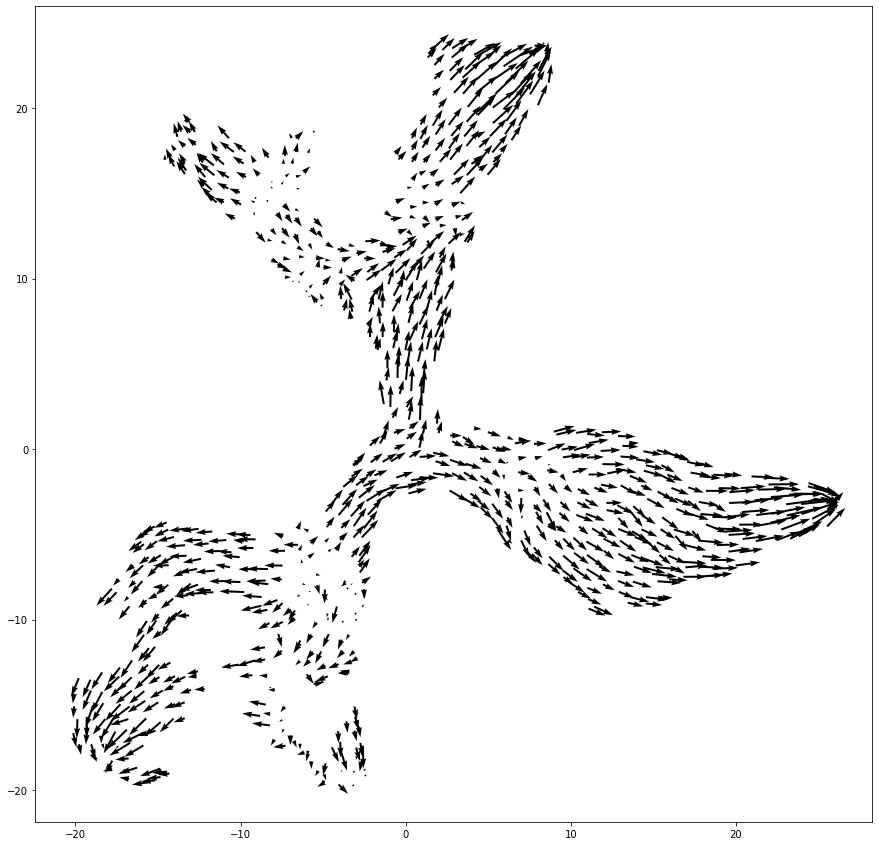

In [8]:
plt.rcParams["figure.figsize"] = (15,15)
plt.quiver(embedding[sampling_ixs, 0],embedding[sampling_ixs, 1],
          velocity_embedding[:,0], velocity_embedding[:,1])

In [9]:
def gaussian_kernel(X, mu=0, sigma=1):
    return np.exp(-(X - mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

In [10]:
def compute_transition_matrix(prob_matrix, embedding, knn_embedding, mix_ratio=0.2):
    
    # sigma_D is set to the average distance between the closest neighbours
    X = pairwise_distances(embedding)
    
    X_temp = X + np.identity(X.shape[0])*X.max()
    near_dist = X_temp.min(axis=0)
    sigma_D = near_dist.mean()
    sigma_W = 0.5 * sigma_D
    W = gaussian_kernel(X, sigma=sigma_W)
    W /= W.sum(1)[:,None]
    
    D = prob_matrix * gaussian_kernel(X, sigma=sigma_D)
    np.fill_diagonal(D, D.max(1))
    D /= D.sum(1)[:,None]
    
    T = W*mix_ratio + D*(1-mix_ratio)
    T /= T.sum(1)[:,None]
    return T, W, D

In [11]:
embedding_lookup = load_raw_data.loc[embedding_downsampling.index]
embedding_lookup = embedding_lookup.drop_duplicates(subset='cellID')
embedding_lookup = embedding_lookup.reset_index(drop=True)

In [12]:
def index(coordinate):
    em1,em2 = coordinate
    tol=0.5
    selected = embedding_lookup[((embedding_lookup.embedding1<em1+tol) 
                                 & (embedding_lookup.embedding1>em1-tol) 
                                 & (embedding_lookup.embedding2<em2+tol) 
                                 & (embedding_lookup.embedding2>em2-tol))]
    return selected.index.to_list()

In [13]:
transition_matrix, W, D = compute_transition_matrix(probability_matrix, 
                                              embedding_downsampling.to_numpy(), 
                                              knn_embedding, 
                                              0.2)

In [14]:
# normalize the velocity to (-1,1)
# allowing leeway 10%

lway = 1.0
velocity = velocity_embedding
(v1_max,v2_max) = velocity.max(axis=0)
(v1_min,v2_min) = velocity.min(axis=0)
velocity /= np.array([max(v1_max,-v1_min), max(v2_max, -v2_min)])
velocity /= lway

# normalize the coordinate to (-1,1)
cell_embedding = embedding_downsampling.to_numpy()
(x1_max,x2_max) = cell_embedding.max(axis=0)
(x1_min,x2_min) = cell_embedding.min(axis=0)
cell_embedding /= np.array([max(x1_max,-x1_min), max(x2_max, -x2_min)])
cell_embedding /= lway

In [15]:
# Question: how is velocity_embedding changed???
velocity_embedding.max()

1.0

In [16]:
# move with closest neighbours
def diffusion(cell_embedding, velocity, init, dt, timestep, n_neighbors, eps = 1e-3):
      
    '''
    Simulation of diffusion of cells in the velocity field
    - velocity of nearest cells (v_net) are used to calculate 
        the velocity of a point in the embedding space
    - init is the initial cell or initial position
    - dt is time step
    - timestep is total number of time steps
    - eps is the criterion to stop a trajectory before timestep (v_net < eps)
    - keep track of the density of the nearest grid.
    '''
    
    # normalize the velocity to make it [-100,100]
    velocity /= max(velocity.max(), -velocity.min())
    nn = NearestNeighbors(n_neighbors=n_neighbors, radius=1, n_jobs=8)
    nn.fit(cell_embedding)
    
    dist, ix1 =  nn.kneighbors(cell_embedding, 10)
    ave_nb_dist = dist.mean(0)
    ave_10_nb_dist = dist.mean(0)[-1]
    
   # This function is slow
   # Need to put position on the mesh grid --> vnet
    def compute_vnet(position):
        nbrs = nn.radius_neighbors(position[None,:], radius=ave_10_nb_dist, return_distance=False)
        if(nbrs[0].any() == 0):
            print("yikes, no neighbour")
            return np.array([0,0])
        return np.mean(np.array([velocity[i] for i in nbrs[0]]), axis = 0)
        
    x0 = cell_embedding[init]
    vnet = velocity[init]
    trajectory = [x0]
    for i in range(timestep):
        x = x0 + vnet*dt
        vnet = compute_vnet(x)
        trajectory.append(x)
        if np.linalg.norm(vnet) < eps:
            print("velocity at ", x, "is too small")
            print("trajectory stopped at time step: ", i)
            break
        #print(i, x, vnet)
        x0 = x

    return trajectory

In [17]:
%%script echo skipping

for traj_num in (0, 334, 178, 582, 250):
    traj = diffusion(embedding_downsampling.to_numpy(),velocity_embedding, traj_num, 0.001, 1000, 100)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)
    plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], s=20, c=range(len(traj)))
    ax.set_aspect('equal', adjustable='box')
plt.show()

skipping


In [682]:
def discretize(coordinate, xmin, xmax, steps):
    
    grid_size = np.array(xmax) - np.array(xmin)
    grid_size = grid_size / np.array(steps)

    grid_idx = np.int64(np.floor((coordinate-xmin)/grid_size))
    grid_coor = xmin + grid_size * (grid_idx + 0.5)
    return grid_idx, grid_coor    

def generate_grid(cell_embedding, velocity_embedding, steps):  
    cell_grid, grid_coor = discretize(cell_embedding, xmin=(-1,-1), xmax=(1,1), steps=steps)
    mesh = np.zeros((steps[0]+1, steps[1]+1, 2))

    cnt = np.zeros((steps[0]+1, steps[1]+1))
    for index in range(cell_grid.shape[0]):
        #print(index)
        i,j = cell_grid[index]
        mesh[i,j] += velocity[index]
        cnt[i,j] += 1

        
    # velocity of the grid = average velocity of the cells in the grid
    for i in range(steps[0]):
        for j in range(steps[1]):
            if cnt[i,j] > 1:
                #print(cnt[i,j], "in cell ", i, j)
                mesh[i,j] /= cnt[i,j]
    
    return mesh


vel_mesh = generate_grid(cell_embedding, velocity, steps=(30,30))

In [683]:
cell_grid, grid_coor = discretize(cell_embedding, xmin=(-1,-1), xmax=(1,1), steps=(30,30))

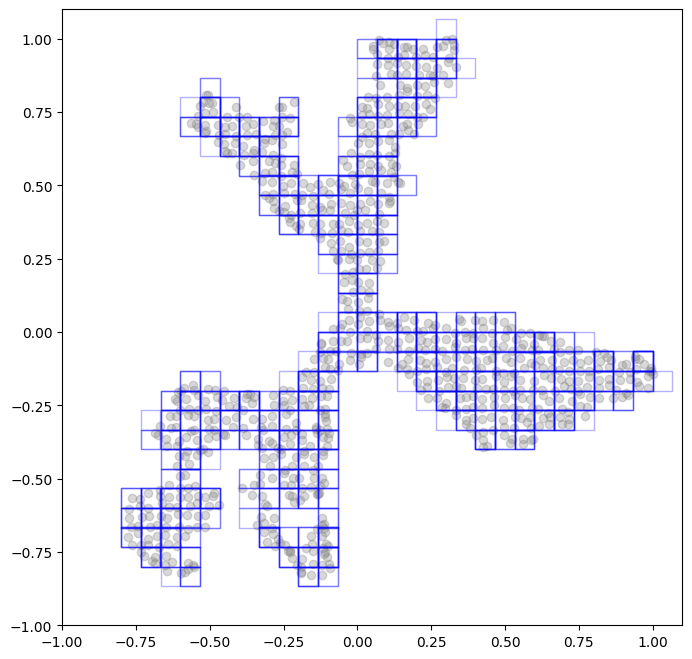

In [717]:
#sanity check
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(cell_embedding[:,0],cell_embedding[:,1], c='grey', alpha = 0.3)
plt.scatter(grid_coor[:,0], grid_coor[:,1], marker='s', color='none', edgecolor='blue', s=200, alpha=0.3)
plt.xlim([-1,1.1])
plt.ylim([-1,1.1])

plt.show()

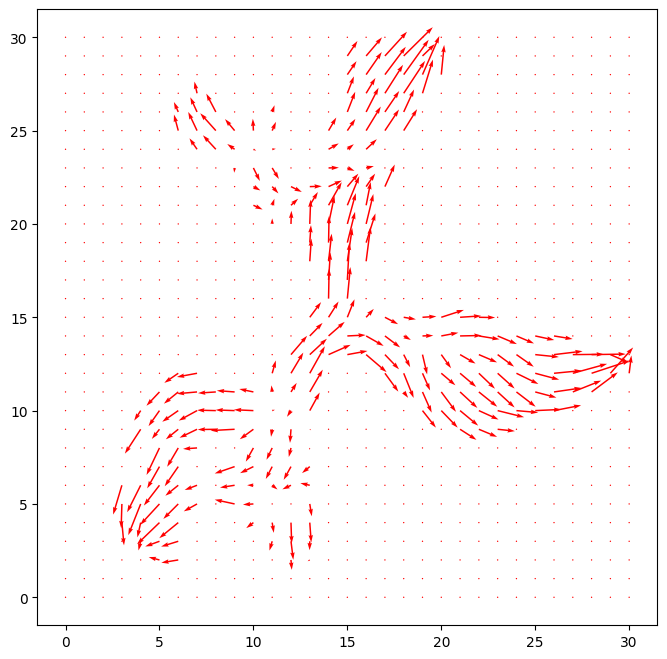

In [718]:
def plot_mesh_velocity(mesh):
    x=list()
    y=list()
    vx=list()
    vy=list()
    for i in range(mesh.shape[0]):
        for j in range(mesh.shape[1]):
            x.append(i)
            y.append(j)
            vx.append(mesh[i,j][0])
            vy.append(mesh[i,j][1])
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.quiver(x,y,vx,vy,color='red',scale = 15)

plot_mesh_velocity(vel_mesh)

In [778]:
def velocity_add_random(velocity, theta, scaling=1):
    '''
    Calculate velocity with randomized kicks
    
    Parameters
    ----------
    
    velocity
        velocity of the grid
    theta
        the angular range that the noise could be affecting the direction of the velocity
        
        
    Maximum effect:
        at theta is set to 0, an angular velocity of magnitude 1/sqrt(2*pi) ~ 0.4 is added.
        
    Return
    ------
    Adjusted velocity for the interested cell
        
    '''
    v = np.linalg.norm(velocity)
    r = np.random.normal(0, theta, 1) * scaling
    v_r = r/v*np.array([-velocity[1], velocity[0]])
    velocity = velocity + v_r
    #print("sin(theta) = ", np.linalg.norm(v_r)/v)
    return v*velocity/np.linalg.norm(velocity)

In [779]:
def diffusion_on_grid(cell_embedding, vel, init, dt=0.1, t_total=10000, eps = 1e-5):
    
    '''
    Simulation of diffusion of cells in the velocity field (on grid)
    
    Parameters
    ----------
    
    cell_embedding
        embedding coordinate for all the cells (downsampled)
    vel
        pre-assigned velocity of each grid
    init
        The initial position (cell_embedding)
    dt 
        Step size of each integration time step
    t_total
        Total number of time steps
    eps 
        Criterion to stop a trajectory before t_total (v_net < eps)
    
    Return
    ------
        a numpy array of coordinates in the trajectory,  shape: (real_n_time_steps, 2)
    '''
    
    
    # TODO: recommmend values of dt and timestep
    x0 = init
    x0_d, dummy = discretize(x0, xmin=(-1,-1), xmax=(1,1), steps=(30,30))
    theta = np.random.uniform(-1,1,1)
    v0 = vel[x0_d[0],x0_d[1]]
    v0 = velocity_add_random(v0, np.pi/12, 1)
    trajectory = [x0]
    
    # trivial cases starting from a destination.
    if np.linalg.norm(v0) < eps:
        #print("initial velocity is too small")
        return trajectory
    
    for i in range(t_total):
        x = x0 + v0*dt
        x_d, dummy = discretize(x, xmin=(-1,-1), xmax=(1,1), steps=(30,30))
        try:
            v = vel[x_d[0],x_d[1]]
            v = velocity_add_random(v, np.pi/4)
        except IndexError:
            #print("out of boundary")
            break
        
        if np.linalg.norm(v) < eps:
            #print("velocity is too small")
            break
        trajectory.append(x)
        x0 = x
        v0 = v

    return np.array(trajectory)

In [427]:
def diffusion_on_grid(cell_embedding, vel, init, dt=0.01, timestep=10000):
    
    # TODO: recommmend values of dt and timestep
    x0 = cell_embedding[init]
    x0_d = discretize(x0)
    v0 = vel[x0_d[0],x0_d[1]]
    trajectory = [x0]
    
    # trivial cases starting from a destination.
    if np.linalg.norm(v0) < 1e-5:
        return trajectory
    
    for i in range(timestep):
        x = x0 + v0*dt
        x_d = discretize(x)
        try:
            v = vel[x_d[0],x_d[1]]
        except IndexError:
            break
        
        if np.linalg.norm(v) < 1e-5:
            break
        trajectory.append(x)
        x0 = x
        v0 = v

    return np.array(trajectory)

In [428]:
def diffusion_on_grid2(cell_embedding, vel, init, dt, timestep):
    
    '''
    Simulation of diffusion of cells in the velocity field
    - velocity of each grid cell is already assigned
    - init is the initial position (cell_embedding)
    - dt is time step
    - timestep is total number of time steps
    - eps is the criterion to stop a trajectory before timestep (v_net < eps)
    '''
    
    x0 = cell_embedding[init]
    x0_d = discretize(x0)
    v0 = vel[x0_d[0],x0_d[1]]
    trajectory = [x0]
    
    # trivial cases starting from a destination.
    if np.linalg.norm(v0) < 1e-5:
        return trajectory
    
    for i in range(timestep):
        x = x0 + v0*dt
        x_d = discretize(x)
        try:
            v = vel[x_d[0],x_d[1]]
        except IndexError:
            break
        
        if np.linalg.norm(v) < 1e-5:
        # consider whether a near grid has velocity
            x0_d = discretize(x0)
            x_1 = np.array([x0[0], x[1]])
            x_2 = np.array([x[0], x0[1]])
            
            v_1 = vel[x0_d[0], x_d[1]]
            v_2 = vel[x_d[0], x0_d[1]]
            
            if np.linalg.norm(v_1)+np.linalg.norm(v_2) < 1e-5:
                trajectory.append(x)
                break
            else:
                x, v = (x_1,v_1) if np.linalg.norm(v_1) > np.linalg.norm(v_2) else (x_2,v_2)
                
        trajectory.append(x)
        x0 = x
        v0 = v

    return np.array(trajectory)

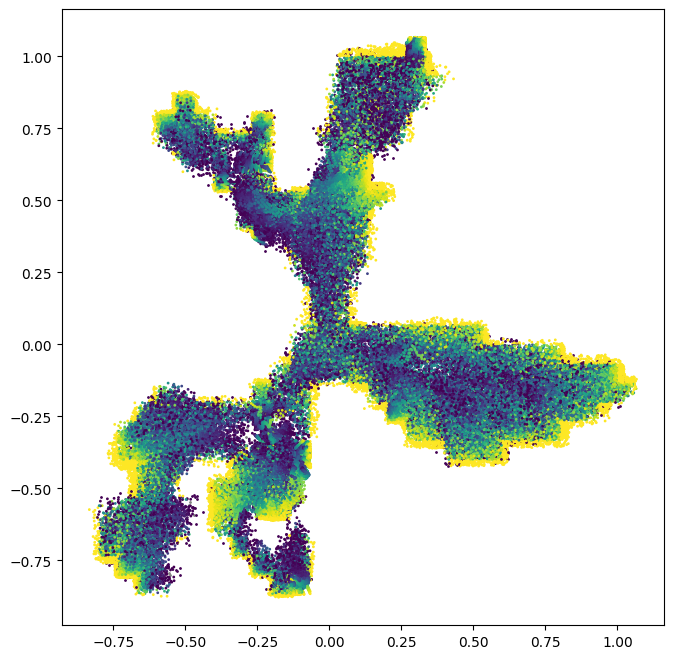

In [783]:
ncells = sampling_ixs.shape[0]
cell_embedding = embedding_downsampling.to_numpy()

CHANGE_INIT=True
if CHANGE_INIT:
    paths = list()
    embedding_range = np.array([2,2])
    step = np.array([30, 30])
    grid_size = embedding_range/steps
    n_positions = 10
    for i in range(ncells):
        for j in range(n_positions):
            init_position = cell_embedding[i] + grid_size * np.random.uniform(-0.5,0.5,2)
            paths.append(diffusion_on_grid(cell_embedding, vel_mesh, init_position, 0.05, 10000))
    paths = np.array(paths)
else:
    paths = np.array(
        [diffusion_on_grid(cell_embedding, vel_mesh, cell_embedding[i], 0.001, 10000)
        for i in range(ncells)]
    )

fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)

idx = 0
for i in paths:
    i = np.array(i)
    plt.scatter(i[:,0], i[:,1], s=1, c=range(len(i)))
    ax.set_aspect('equal', adjustable='box')

plt.show()

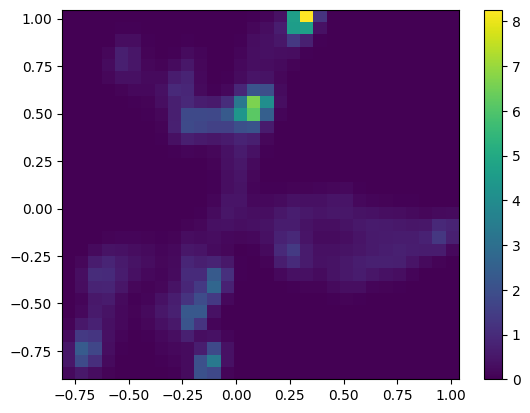

In [782]:
x = list()
y = list() 
for i in paths:
    i = np.array(i)
    for j in i[:,0]:
        x.append(j)
    for k in i[:,1]:
        y.append(k)

x = np.array(x)
y = np.array(y)

from scipy.stats import kde
 

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=30
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
plt.colorbar()
plt.show()

In [23]:
%%script echo skipping
traj2 = list()
for i in range(891):
    traj2.append(diffusion_on_grid2(embedding_downsampling.to_numpy(),vel_mesh, i, 0.005, 5000))

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)

for i in traj2:
    plt.scatter(np.array(i)[:,0], np.array(i)[:,1], s=1, c=range(len(i)))
    ax.set_aspect('equal', adjustable='box')

plt.show()

skipping


In [24]:
%%script echo skipping
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)

for i in traj2:
    plt.scatter(np.array(i)[-1,0], np.array(i)[-1:,1], s=5, c='red')
    ax.set_aspect('equal', adjustable='box')

plt.show()

skipping


In [25]:
%%script echo skipping
# vel_mesh interpolation/extrapolation.

x = np.arange(0,steps[0]+1,1)
y = np.arange(0,steps[1]+1,1)
X, Y = np.meshgrid(x,y)

sx = list()
sy = list()
vx = list()
vy = list()

for i in range(vel_mesh.shape[0]):
    for j in range(vel_mesh.shape[1]):
        if np.linalg.norm(vel_mesh[i,j]) > 0:
            sx.append(i)
            sy.append(j)
            vx.append(vel_mesh[i,j][0])
            vy.append(vel_mesh[i,j][1])
points = np.transpose(np.vstack((sx, sy)))

vx_interp = interpolate.griddata(points, vx, (X, Y), method='linear')
vy_interp = interpolate.griddata(points, vy, (X, Y), method='linear')

skipping


In [26]:
%%script echo skipping
plt.figure(1)
plt.quiver(sx, sy, vx, vy)
plt.figure(2)
plt.quiver(X, Y, vx_interp, vy_interp)
plt.show()

skipping


In [27]:
%%script echo skipping
for i in range(vel_mesh.shape[0]):
    for j in range(vel_mesh.shape[1]):
        vel_mesh[i,j]=np.array([vx_interp[i,j],vy_interp[i,j]])

skipping


In [28]:
%%script echo skipping
traj3 = list()


a = np.nan_to_num(vel_mesh)
for i in range(891):
    traj3.append(diffusion_on_grid(embedding_downsampling.to_numpy(),a, i, 0.0005, 5000))

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)

for i in traj3:
    plt.scatter(np.array(i)[:,0], np.array(i)[:,1], s=5, c=range(len(i)))
    ax.set_aspect('equal', adjustable='box')

plt.show()

skipping


In [29]:
def compute_trajectory_displacement(traj):
    traj = np.array(traj)
    return np.linalg.norm(traj[-1,:] - traj[0,:])

In [482]:
def compute_trajectory_length(traj1):
    temp = traj1[:-1,:] - traj1[1:,:]
    length = np.sum(np.sqrt(np.sum(temp**2, axis=1)))
    return length

def compute_trajectory_similarity(traj1, traj2, numPicks=10):
    '''
    Computes the similarity between two curves based on average distance of a selection of closest pairs

    Input: 
    - numpy arrays (nsteps1, 2), (nsteps2, 2); nsteps1 >= nsteps2 
    - numPicks: number of representative points on the shorter curve traj2
    Return: a float number
    '''
    # assert traj1 longer than traj2
    # empty traj2
    if not traj2.size:
        print("empty trajectory here!")
        raise 
    # pick N points evenly from traj2
    idx = np.round(np.linspace(0, len(traj2) - 1, numPicks)).astype(int)
    
    # in the case the shorter trajectory is less than numPicks timesteps
    idx = np.unique(idx)
    
    temp = traj1 - traj2[idx, None]
    A = np.min(np.sum(temp**2, axis=2), axis=1)
    
    return np.mean(A**(1/2))

In [484]:
def compute_similarity_matrix(traj, numPicks=10):
    import itertools
    traj_length = np.array([compute_trajectory_length(np.array(i)) for i in traj])
    traj_order = np.argsort(traj_length) # 1d array
    
    ncells = len(traj_order)
    simMat = np.zeros((ncells,ncells))
    pairList=list()
    for i,j in itertools.combinations(traj_order, 2):
            # length of traj[i] <= traj[j]
            simMat[i,j] = compute_trajectory_similarity(np.array(traj[j]), np.array(traj[i]), numPicks)
            simMat[j,i] = simMat[i,j]
    return simMat

similarity_matrix_10 = compute_similarity_matrix(traj, numPicks=10)

In [485]:
flat_dist_mat = squareform(similarity_matrix_10)
sim_linkage = linkage(flat_dist_mat, method='complete', preserve_input=False)

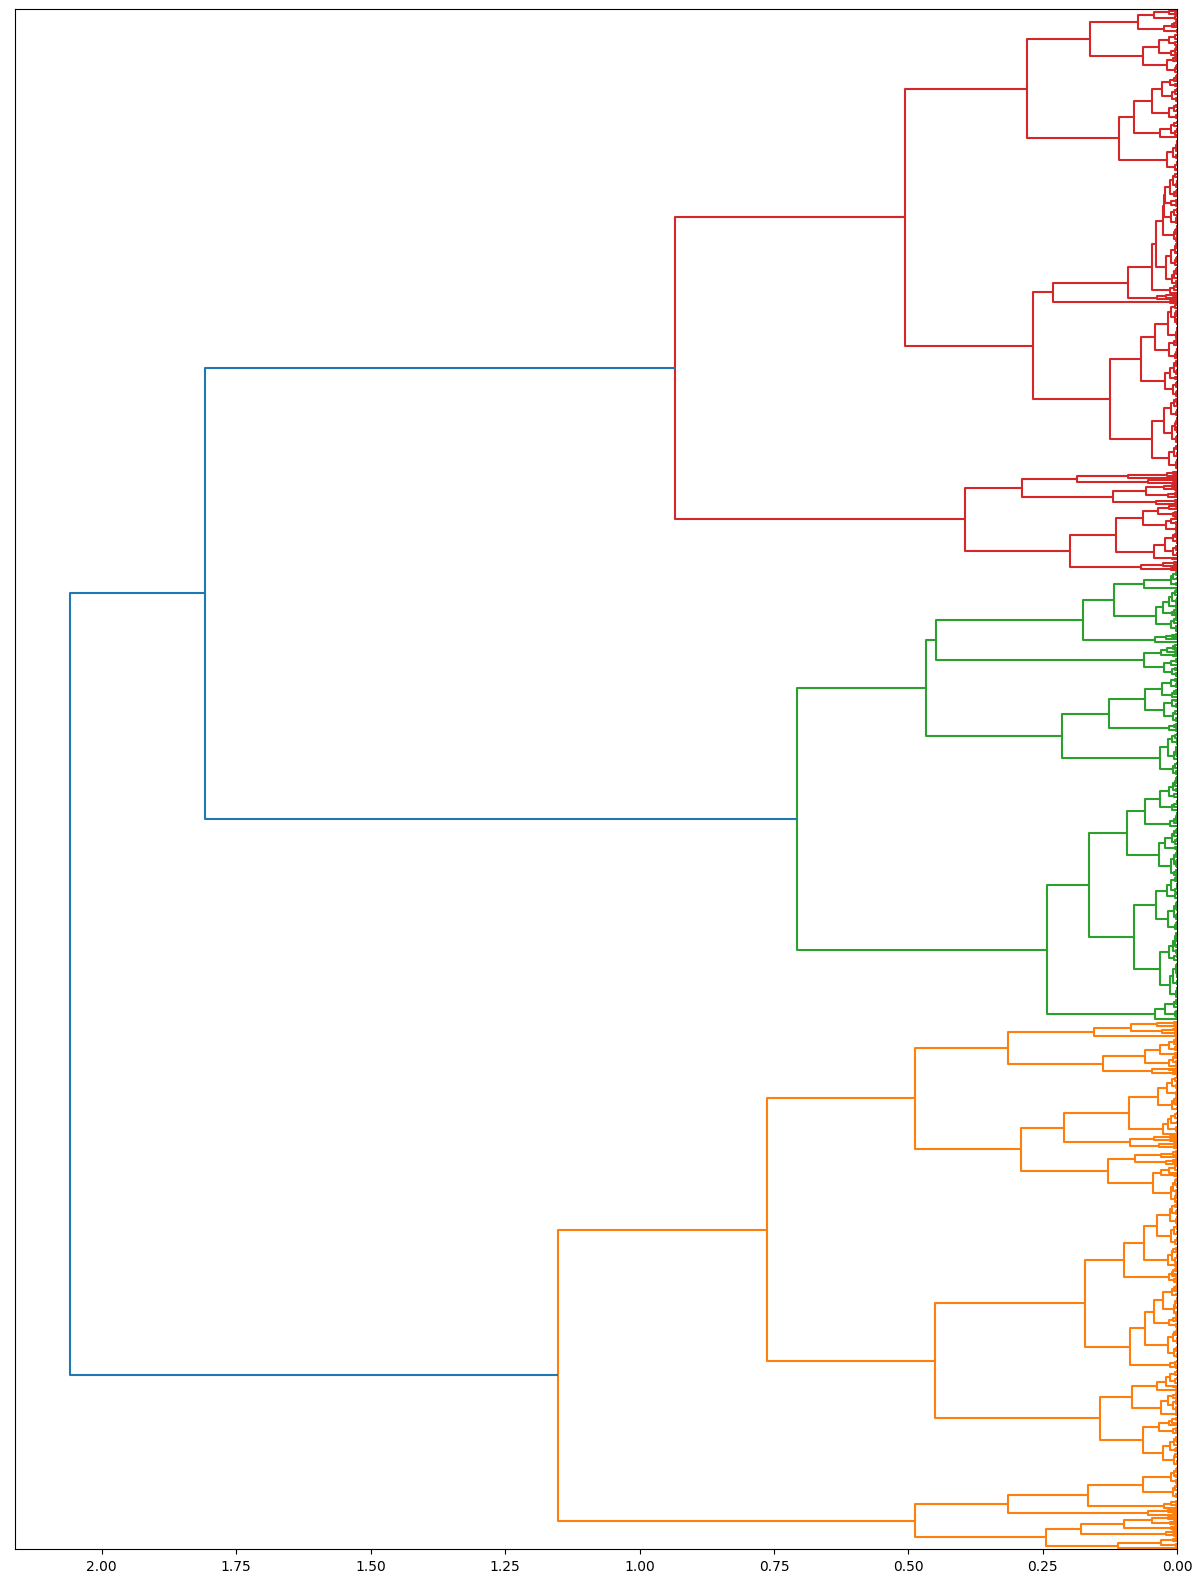

In [486]:
plt.rcParams['figure.figsize']=(15,20)

labelList = list(range(7))
dn = dendrogram(sim_linkage, 
                orientation='left',
                no_labels=True,
               show_leaf_counts=True)
plt.rcdefaults()
plt.show()

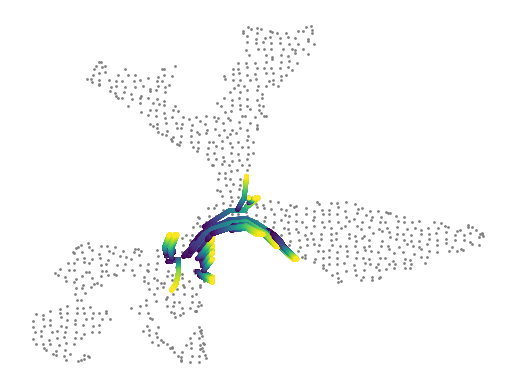

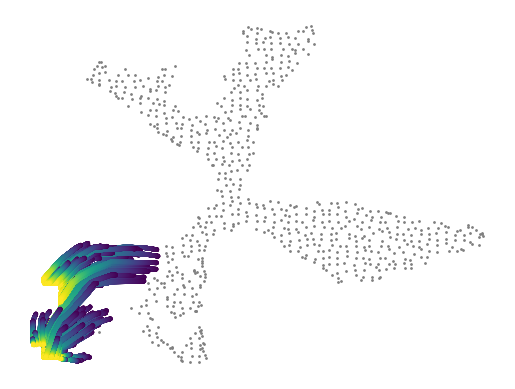

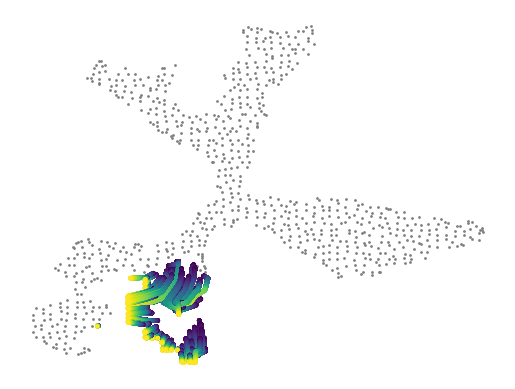

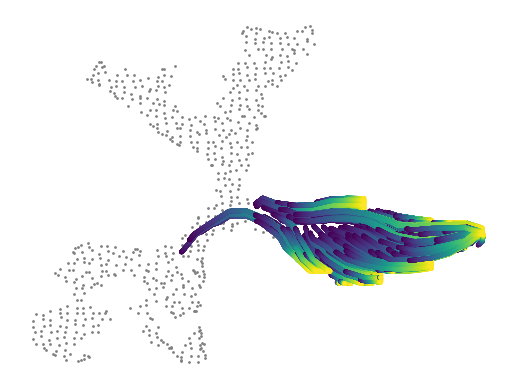

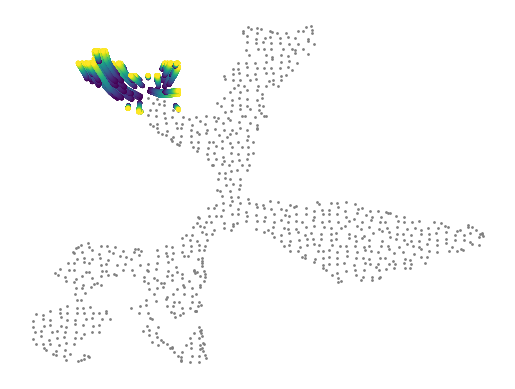

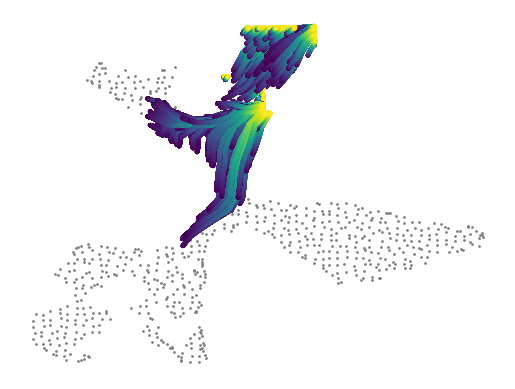

In [487]:
nclusters = 6
traj_cluster = list()

cluster_label = fcluster(sim_linkage, t=nclusters, criterion='maxclust')

for i in range(nclusters):
    traj_cluster = np.where(cluster_label == i+1)[0].tolist()
    if len(traj_cluster) < num_traj_threshold:
        continue
    plot_trajs(embedding_downsampling, traj_cluster, i+1)
    
plt.rcParams['figure.figsize']=(5,5)
plt.rcdefaults()
plt.show()

In [560]:
def clustering(clusters, traj, traj_length, similarity_threshold, nkeep=10):
    '''
    a clustering method to find representative paths.
    
    traj -> N trajectories, sorted by its |displacement|, each trajectory is a (ntimestep, 2) array
    traj_length -> |displacement| of the trajectories (N, )
    
    After each iteration, a number of trajectories are popped in the traj list as well as the traj_length list.
    returns a list of clusters
    '''
    print("There are ", len(clusters), "clusters. \t\t", len(traj), "paths to be categorized")
    if not traj.size:
        return clusters
    
    longest = traj[0]
    #print(traj_length)
    similarity = np.array([compute_trajectory_similarity(np.array(longest),
                                                         np.array(ipath), 10
                                                        ) 
                           for ipath in traj])
    sel = similarity < similarity_threshold
    clusters.append(traj[sel][:nkeep])
    
    traj = traj[~sel]
    traj_length = traj_length[~sel]
    return clustering(clusters, traj, traj_length, similarity_threshold, nkeep)
    

In [489]:
traj_displacement = np.array([compute_trajectory_displacement(ipath) for ipath in paths])
order = np.argsort(traj_displacement)[::-1]
sorted_traj = paths[order]
traj_displacement=traj_displacement[order]

In [522]:
clusters = list()
clusters = clustering(clusters, sorted_traj, traj_displacement, 0.1, nkeep=10)

There are  0 clusters. 
 890 paths to be categorized
There are  1 clusters. 
 750 paths to be categorized
There are  2 clusters. 
 614 paths to be categorized
There are  3 clusters. 
 545 paths to be categorized
There are  4 clusters. 
 418 paths to be categorized
There are  5 clusters. 
 329 paths to be categorized
There are  6 clusters. 
 268 paths to be categorized
There are  7 clusters. 
 214 paths to be categorized
There are  8 clusters. 
 199 paths to be categorized
There are  9 clusters. 
 181 paths to be categorized
There are  10 clusters. 
 142 paths to be categorized
There are  11 clusters. 
 88 paths to be categorized
There are  12 clusters. 
 75 paths to be categorized
There are  13 clusters. 
 63 paths to be categorized
There are  14 clusters. 
 34 paths to be categorized
There are  15 clusters. 
 23 paths to be categorized
There are  16 clusters. 
 14 paths to be categorized
There are  17 clusters. 
 6 paths to be categorized
There are  18 clusters. 
 5 paths to be catego

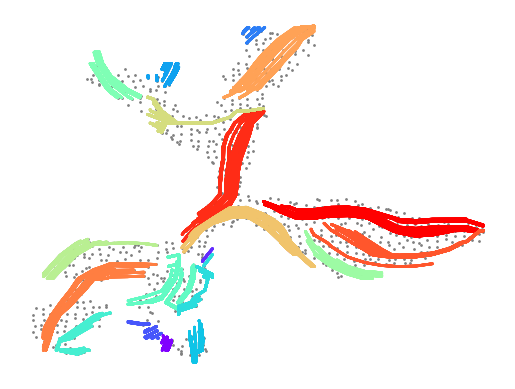

In [523]:
def vis_path_clusters(cell_embedding, clusters):
    from matplotlib.pyplot import cm

    plt.scatter(cell_embedding.embedding1, cell_embedding.embedding2, c='gray', s=1)
    
    color = iter(cm.rainbow_r(np.linspace(0, 1, len(clusters))))

    for cluster in clusters:
        cl = next(color)
        for ipath in cluster:
            c = np.repeat(cl[None,:],len(ipath), axis=0)
            plt.scatter(np.array(ipath)[:,0], np.array(ipath)[:,1], s=1, c=c)
            plt.axis('off')
        
    plt.show()
    

vis_path_clusters(embedding_downsampling, clusters)

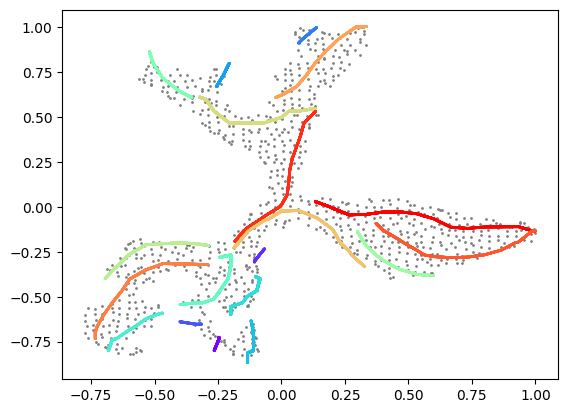

In [524]:
from matplotlib.pyplot import cm
color = iter(cm.rainbow_r(np.linspace(0, 1, len(clusters))))


plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c = "gray", s = 1)
for i in clusters:
    cl = next(color)
    c = np.repeat(cl[None,:],len(i[0]), axis=0)


    plt.scatter(i[0][:,0], i[0][:,1],s=1,c=c)
plt.show()

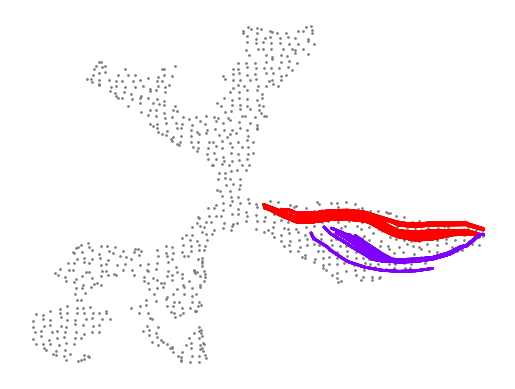

In [577]:
vis_path_clusters(embedding_downsampling, [clusters[0], clusters[2]])

In [540]:
new_path = np.array([path for cluster in clusters for path in cluster])

In [559]:
new_clusters = list()
traj_displacement = np.array([compute_trajectory_displacement(ipath) for ipath in new_path])
order = np.argsort(traj_displacement)[::-1]
sorted_traj = new_path[order]
traj_displacement=traj_displacement[order]

new_clusters = clustering(new_clusters, sorted_traj, traj_displacement, 0.3, nkeep=200)

There are  0 clusters. 
 173 paths to be categorized
[0.8820879  0.87533815 0.84612564 0.80383056 0.79216038 0.7898238
 0.77064178 0.76188459 0.74198534 0.74086145 0.73798125 0.72793648
 0.71760276 0.71389023 0.69036221 0.67163926 0.66339434 0.64206675
 0.64095794 0.63970946 0.62946624 0.60609954 0.59936229 0.5991606
 0.58313671 0.58045254 0.57709749 0.57537758 0.57236934 0.56612238
 0.53427627 0.53222878 0.53102904 0.53072249 0.52733849 0.52606388
 0.52066383 0.51627881 0.51618369 0.51486379 0.50740218 0.50546056
 0.50456093 0.49087726 0.48208989 0.4795416  0.46470519 0.46032457
 0.45692656 0.45367653 0.44863335 0.44793976 0.44620673 0.44274026
 0.43761232 0.43448419 0.43380963 0.43358138 0.43180345 0.43155857
 0.42934362 0.42625282 0.42394431 0.42106653 0.41738041 0.41328509
 0.39634435 0.39608218 0.39461063 0.39396844 0.39101665 0.38805594
 0.37477327 0.33302246 0.31375084 0.30761607 0.30636757 0.30237805
 0.29918228 0.29789291 0.29758545 0.29718346 0.29349426 0.2834923
 0.28337408 

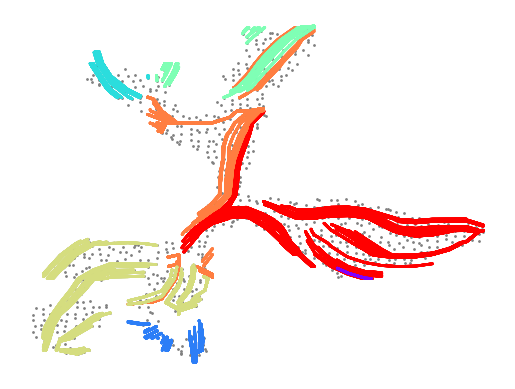

In [557]:
vis_path_clusters(embedding_downsampling, new_clusters)